In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [3]:
library(ggrepel)
library(DOSE)
library(org.Mm.eg.db)
library(clusterProfiler)
library(enrichplot)
library(msigdbr)

DOSE v3.28.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609




In [2]:
setwd(dir = '/home/wpy/stereoseq/20240502-SPACseq')
tab <- read.csv('./bulkdata/Group_sgCd44_vs_sginter_DESeq2.txt', sep='\t') %>% drop_na() %>% filter(.$padj < 1)

In [8]:
tab %>% write.table('./bulkdata/Group_sgCd44_vs_sginter_DESeq2_clean.txt', sep='\t', quote=F)

In [5]:
library(ggrepel)

Warning message:
“ggrepel: 197 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


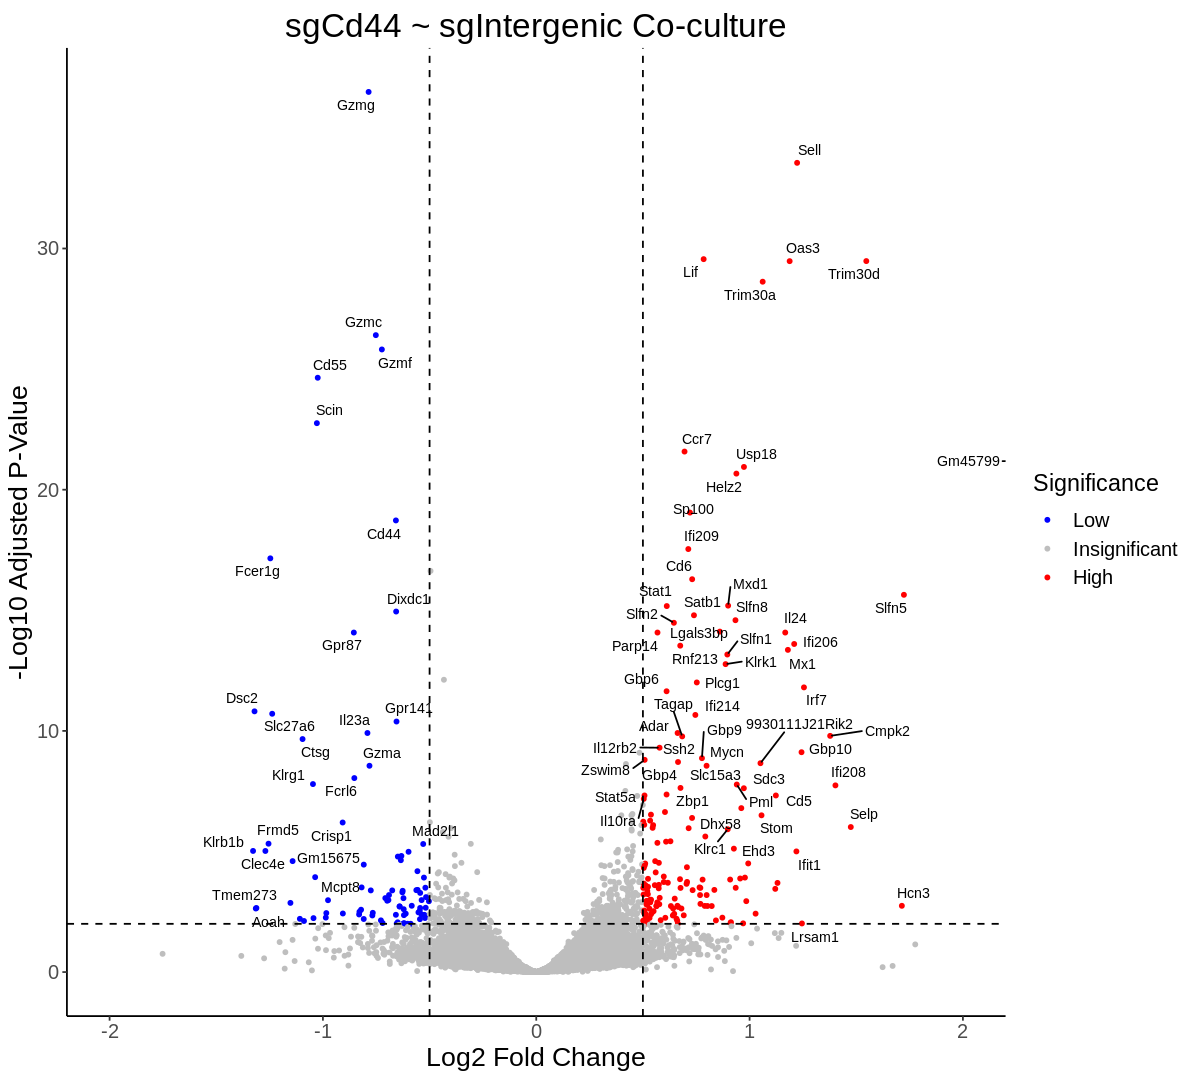

In [6]:
options(repr.plot.width=10,repr.plot.height=9)

tab$color = 'Insignificant'
tab$color[tab$log2FoldChange > 0.5 & tab$padj < 0.01] = 'High'
tab$color[tab$log2FoldChange < -0.5 & tab$padj < 0.01] = 'Low'
tab$color = factor(tab$color, levels = c('Low','Insignificant','High'))

p <- ggplot(tab, aes(x = log2FoldChange, y = -log10(padj))) +
  geom_point(aes(color=color), size = 1) +
  scale_color_manual(values = c("blue", "grey", "red")) +
  theme_classic()+
  labs(
    title = "sgCd44 ~ sgIntergenic Co-culture",
    x = "Log2 Fold Change",
    y = "-Log10 Adjusted P-Value",
    color = 'Significance'
  ) +
  coord_cartesian(xlim = c(-2,2))+
  geom_hline(yintercept = -log10(0.01), linetype = "dashed", color = "black") +
  geom_vline(xintercept = c(-0.5, 0.5), linetype = "dashed", color = "black") +
  geom_text_repel(
    data = subset(tab, (padj < 0.01) & (abs(log2FoldChange) > 0.5)),
    aes(label = Gene_name),
    size = 3, max.overlaps = 10 # 调整注释文字的大小和避免重叠
  )

p <- p + theme(
  plot.title = element_text(size = 20, hjust=0.5, vjust=0.3),  # 标题大小
  axis.title = element_text(size = 16),  # 轴标题大小
  axis.text = element_text(size = 12),   # 坐标轴标签大小
  legend.title = element_text(size = 14),
  legend.text = element_text(size = 12)  # 图例文本大小
)

print(p)
# ggsave('co-culture.pdf', p, dpi=600)

In [5]:
gene_list <- tab %>% filter(padj < 1e-2) %>% filter(log2FoldChange > 0.5)

ego <- enrichGO(gene          = gene_list$Gene_name, 
                OrgDb         = org.Mm.eg.db, 
                ont           = "BP", 
                keyType = "SYMBOL",
                pAdjustMethod = "fdr", 
                pvalueCutoff  = 0.05,
                qvalueCutoff  = 0.2,
                readable = T)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


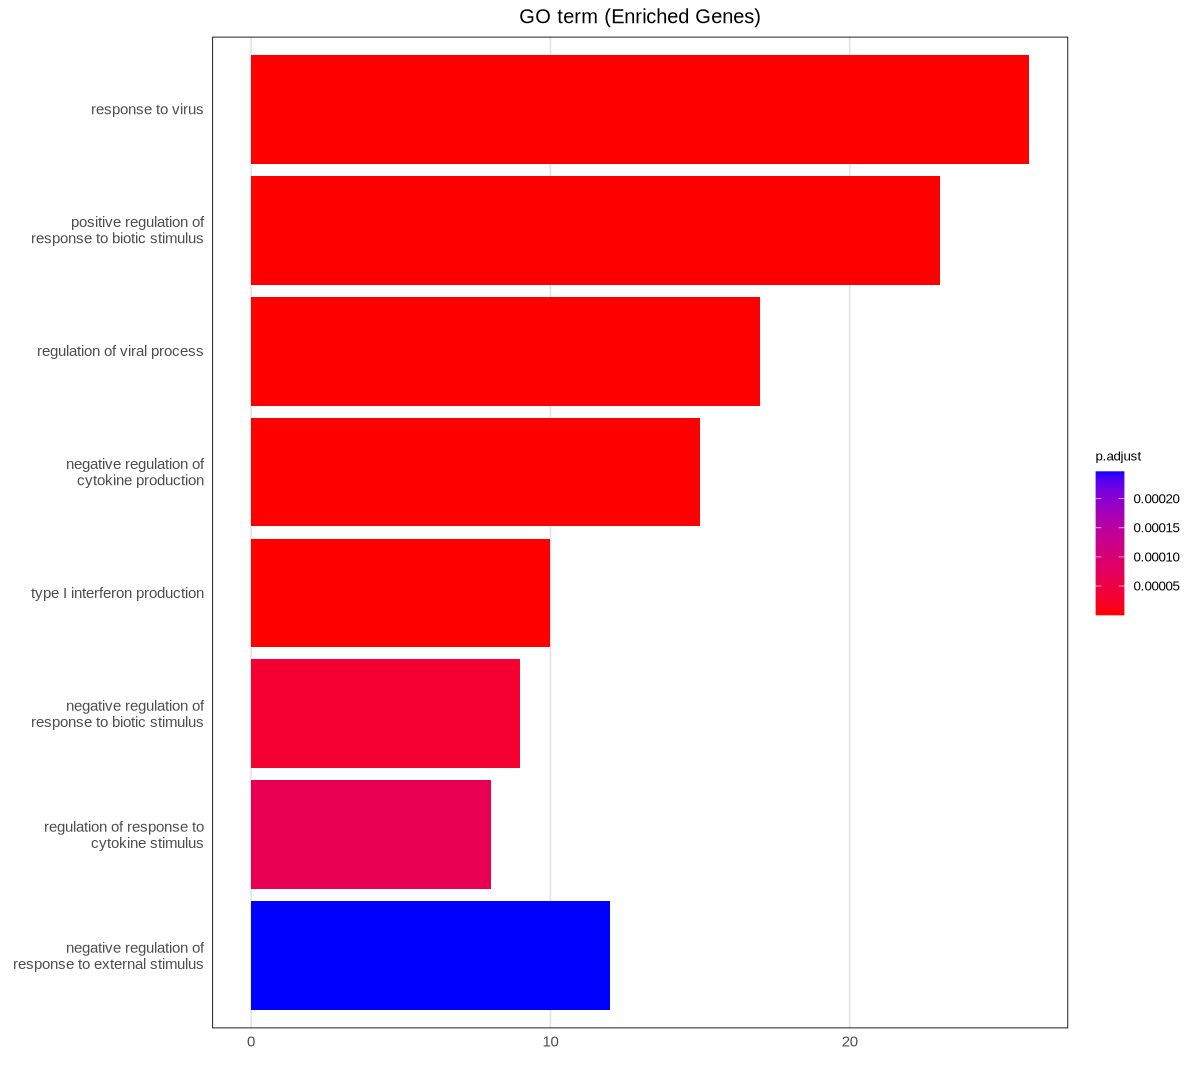

In [18]:
ego2 = simplify(ego, cutoff=0.7, by="p.adjust", select_fun=min)
ego3 = gofilter(ego2, level = 4)

# 绘制GO富集分析的条形图
p <- barplot(ego3, 
            showCategory = 8,
            font.size = 10) +
  ggtitle("GO term (Enriched Genes)") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 12, hjust = 0.5),
    axis.title.x = element_text(size = 10),
    axis.title.y = element_blank(), 
    axis.text = element_text(size = 9),
    panel.grid.major.x = element_line(color = "gray90"),
    panel.grid.major.y = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_rect(color = "black", fill = NA), # 添加外框
    legend.position = "right",
    legend.title = element_text(size = 8),
    legend.text = element_text(size = 8)
  ) +
  scale_fill_gradient(
    low = "red", # 调整顺序为红色在上
    high = "blue", # 蓝色在下
    name = "p.adjust"
  ) +
  xlab("")

# 保存图片
ggsave('./plots/co-culture_up_go.pdf', p, width = 5, height = 6)

print(p)

In [16]:
gene_list <- tab %>% filter(padj < 1e-2) %>% filter(log2FoldChange < -0.5)

ego_low <- enrichGO(gene          = gene_list$Gene_name, 
                OrgDb         = org.Mm.eg.db, 
                ont           = "BP", 
                keyType = "SYMBOL",
                pAdjustMethod = "fdr", 
                pvalueCutoff  = 0.05,
                qvalueCutoff  = 0.2,
                readable = T)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


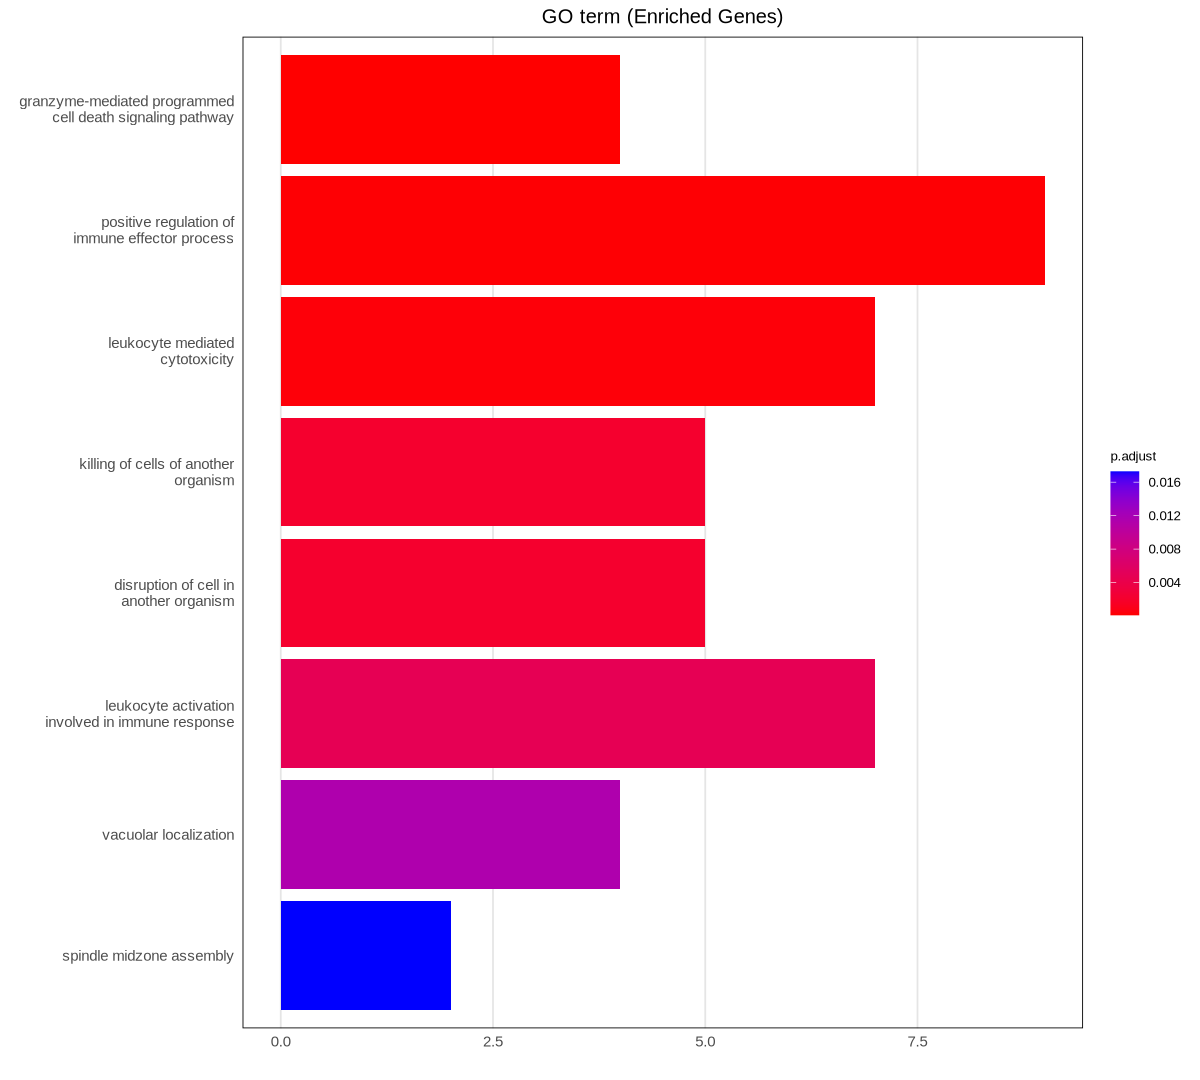

In [19]:
ego2_low = simplify(ego_low, cutoff=0.7, by="p.adjust", select_fun=min)
ego3_low = gofilter(ego2_low, level = 4)

# 绘制GO富集分析的条形图
p <- barplot(ego3_low, 
            showCategory = 8,
            font.size = 10) +
  ggtitle("GO term (Enriched Genes)") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 12, hjust = 0.5),
    axis.title.x = element_text(size = 10),
    axis.title.y = element_blank(), 
    axis.text = element_text(size = 9),
    panel.grid.major.x = element_line(color = "gray90"),
    panel.grid.major.y = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_rect(color = "black", fill = NA), # 添加外框
    legend.position = "right",
    legend.title = element_text(size = 8),
    legend.text = element_text(size = 8)
  ) +
  scale_fill_gradient(
    low = "red", # 调整顺序为红色在上
    high = "blue", # 蓝色在下
    name = "p.adjust"
  ) +
  xlab("")

# 保存图片
ggsave('./plots/co-culture_down_go.pdf', p, width = 5, height = 6)

print(p)

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Saving 7 x 7 in image
Warning message:
“ggrepel: 221 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 221 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


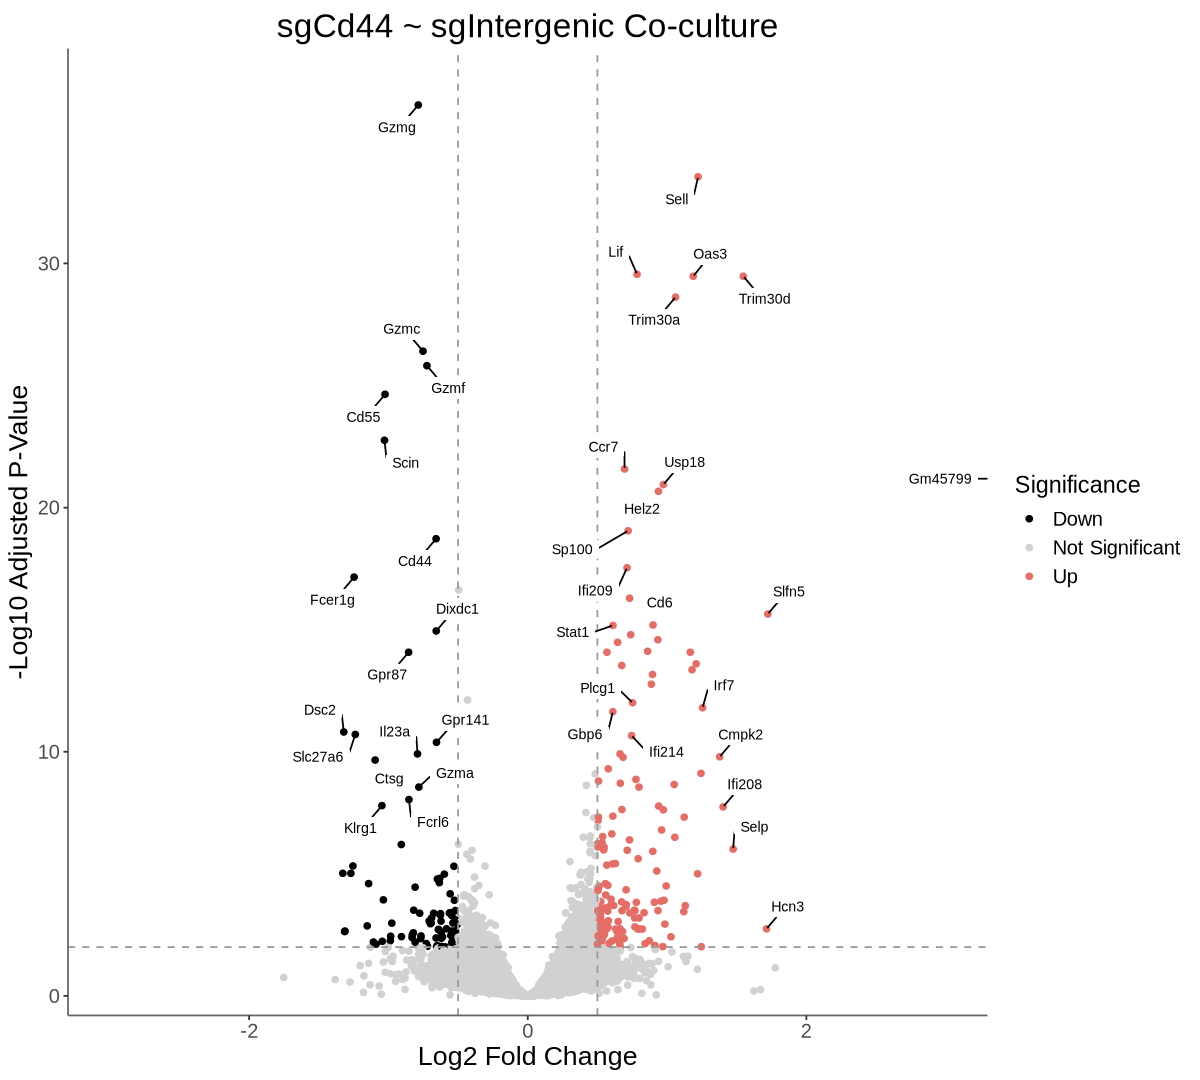

In [9]:
library(ggplot2)
library(ggrepel)

# Assign colors based on fold change and significance
tab$color <- 'Not Significant'
tab$color[tab$log2FoldChange > 0.5 & tab$padj < 0.01] <- 'Up'
tab$color[tab$log2FoldChange < -0.5 & tab$padj < 0.01] <- 'Down'
tab$color <- factor(tab$color, levels = c('Down', 'Not Significant', 'Up'))

# Create the plot with soft colors and labeled genes
p <- ggplot(tab, aes(x = log2FoldChange, y = -log10(padj))) +
  geom_point(aes(color = color), size = 1.5) +
  scale_color_manual(values = c("#000000", "#D1D1D1", "#E66D65")) +  # Softer colors
  theme_classic() +
  labs(
    title = "sgCd44 ~ sgIntergenic Co-culture",
    x = "Log2 Fold Change",
    y = "-Log10 Adjusted P-Value",
    color = 'Significance'
  ) +
  coord_cartesian(xlim = c(-3, 3), ylim = c(1, 37)) +
  geom_hline(yintercept = -log10(0.01), linetype = "dashed", color = "gray60") +
  geom_vline(xintercept = c(-0.5, 0.5), linetype = "dashed", color = "gray60") +
  geom_label_repel(
    data = subset(tab, (padj < 0.01) & (abs(log2FoldChange) > 0.5)),
    aes(label = Gene_name),
    size = 3, fill = "white",
    box.padding = 0.4,
    label.size = 0,  # 去除label外围的框
    label.r = unit(0.2, "lines"), # Rounded corners
    color = "black"
  ) +
  theme(
    plot.title = element_text(size = 20, hjust = 0.5, vjust = 0.3),  # Title size
    axis.title = element_text(size = 16),  # Axis title size
    axis.text = element_text(size = 12),   # Axis label size
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12),  # Legend text size
    axis.line = element_line(size = 0.5, color = "gray40"), # Softer axis lines
    panel.grid.major = element_blank(), panel.grid.minor = element_blank() # Clean gridlines
  )

# Save the plot
ggsave('co-culture_updated.pdf', p, dpi=600)

print(p)

In [7]:
tab_high <- tab %>% filter(.$log2FoldChange > 0.4) %>% filter(.$padj < 1e-15)
tab_low <- tab %>% filter(.$log2FoldChange < 0.4) %>% filter(.$padj < 1e-15)

print(nrow(tab_high))
print(nrow(tab_low))

[1] 15
[1] 8
[1] 8


In [10]:
tab_high <- tab %>% filter(.$color == 'Up')
tab_low <- tab %>% filter(.$color == 'Down')

print(nrow(tab_high))
print(nrow(tab_low))

[1] 159
[1] 89
[1] 89


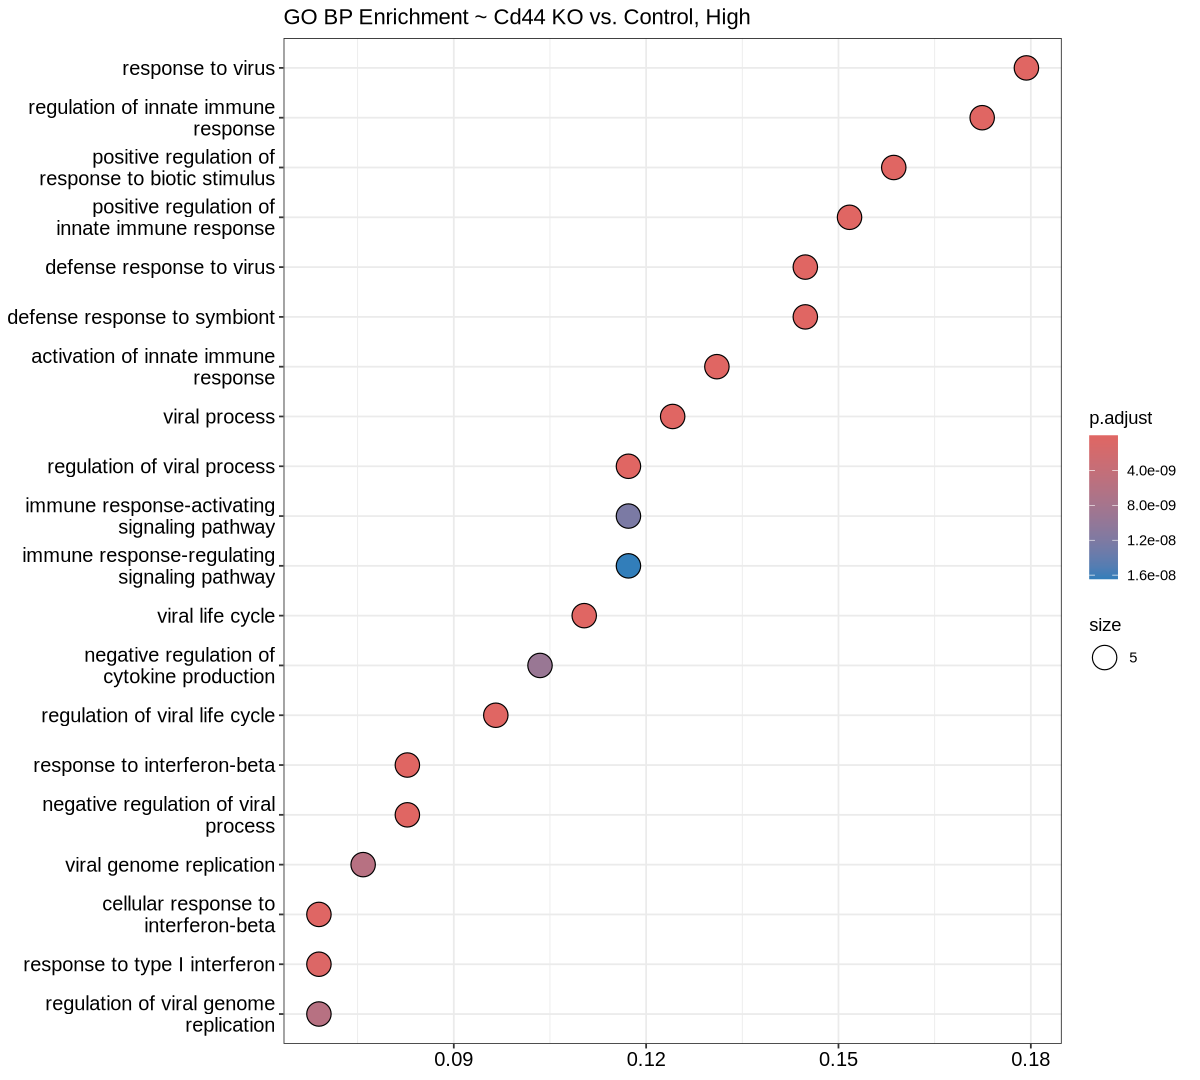

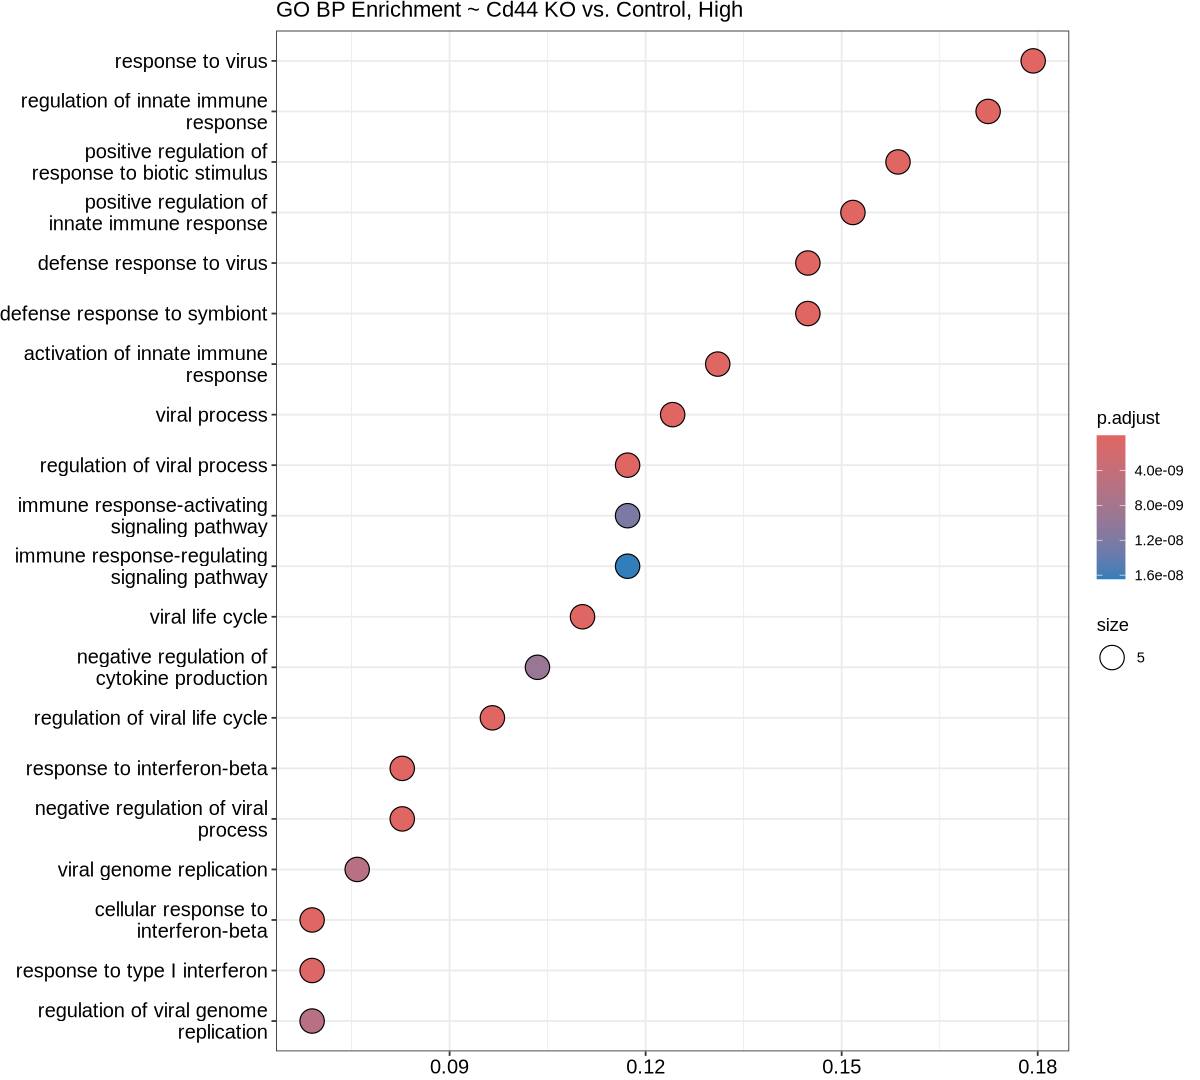

In [76]:
# _df <- msigdbr(species = "Mus musculus", category = "H")
# hallmark_sets <- m_df %>% select(c('gs_name', 'gene_symbol'))
# hallmark_enrich <- enricher(tab_high$Gene_name, TERM2GENE = hallmark_sets, pvalueCutoff = 0.05)

# hallmark_enrich@result$Description <- gsub("HALLMARK_", "", hallmark_enrich@result$Description)
# hallmark_enrich@result$color <- ifelse(hallmark_enrich@result$Description %in% c('EPITHELIAL_MESENCHYMAL_TRANSITION', 'INTERFERON_ALPHA_RESPONSE', 'INTERFERON_GAMMA_RESPONSE'), 'red', 'black')

# dotplot(hallmark_enrich, showCategory=20) + ggtitle("Hallmark Enrichment ~ Cd44 KO vs. Control") +
# theme(axis.title.x = element_blank(),  # 去除 x 轴标签
#       axis.title.y = element_blank())  # 去除 y 轴标签

go_enrich <- enrichGO(
  gene          = tab_high$Gene_name,
  OrgDb         = org.Mm.eg.db,  # 使用小鼠的基因数据库
  keyType       = "SYMBOL",      # 基因列表中的基因是符号形式
  ont           = "BP",          # 使用Biological Process
  pAdjustMethod = "BH",          # 使用Benjamini-Hochberg方法校正p值
  pvalueCutoff  = 0.05,          # p值阈值
  qvalueCutoff  = 0.05,          # q值阈值
  readable      = TRUE            # 将结果转换为更具可读性的基因名称
)

# 查看富集结果
# print(go_enrich)

# 如果有特定的条目需要标记颜色，可以像之前一样修改描述字段
# go_enrich@result$color <- ifelse(go_enrich@result$Description %in% c('apoptotic process', 'cell cycle', 'immune response'), 'red', 'black')

# 绘制富集分析结果的dotplot
p <- dotplot(go_enrich, showCategory=20, size = 5) +  # 调整点的大小
  ggtitle("GO BP Enrichment ~ Cd44 KO vs. Control, High") +
  theme(axis.title.x = element_blank(),  # 去除 x 轴标签
        axis.title.y = element_blank())
print(p)
print(p + theme(plot.margin = margin(1, 1, 1, 1)))  # 调整图的边距以适应显示

ggsave('./plots/bulk.go_bp_enrichment_updated.pdf', p, width = 7, height = 9)  # 设置图片大小为6.5 x 4

Saving 6.67 x 6.67 in image
Warning message in plot_theme(plot):
“The `plot.legend` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `plot.legend` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `plot.legend` theme element is not defined in the element hierarchy.”


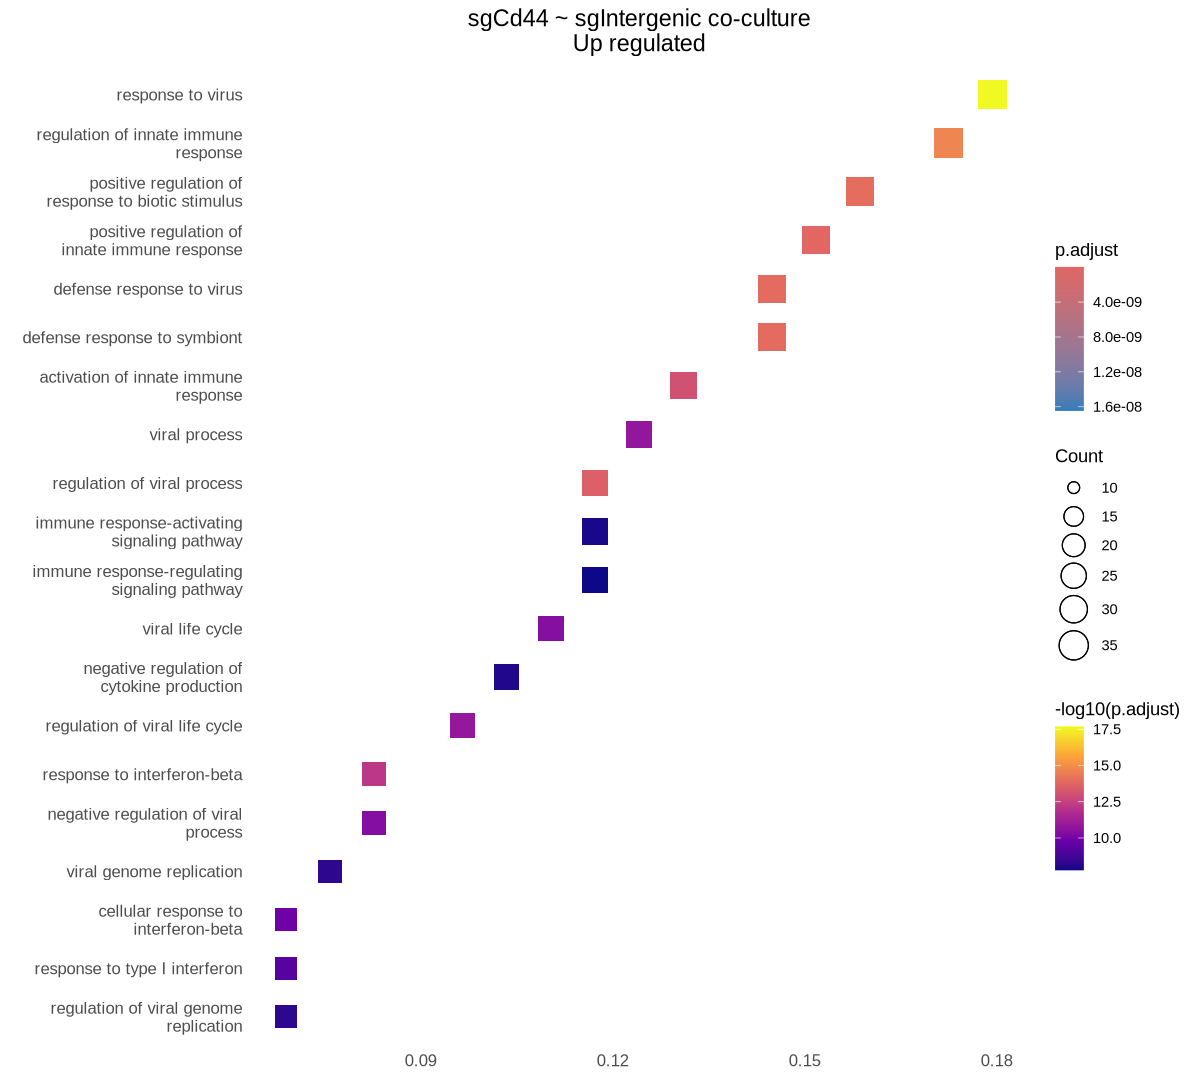

In [25]:
# Adjust color and other plot aesthetics
p <- dotplot(go_enrich, showCategory = 20) + 
  geom_point(aes(color = -log10(p.adjust), size = Count + 10), shape = 15) +  # Manually set shape to squares (15)
  scale_color_viridis_c(option = "C") +  # Use a visually distinct color palette
  theme_minimal() +  # Clean up grid and background
  theme(
    axis.text.x = element_text(size = 10),  # Adjust x-axis text size
    axis.text.y = element_text(size = 10),  # Adjust y-axis text size
    plot.title = element_text(size = 14, hjust = 0.5),  # Title size and alignment
    axis.title.x = element_blank(),  # Remove x-axis label
    axis.title.y = element_blank(),   # Remove y-axis label
    plot.legend = element_blank(),
    panel.grid = element_blank()
  ) +
  ggtitle("sgCd44 ~ sgIntergenic co-culture\nUp regulated")

# Save the updated plot
ggsave('go_bp_enrichment_updated.pdf', p, dpi = 600)

print(p)

In [15]:
write.table(go_enrich@result, 'high.csv', sep='\t', quote=F)

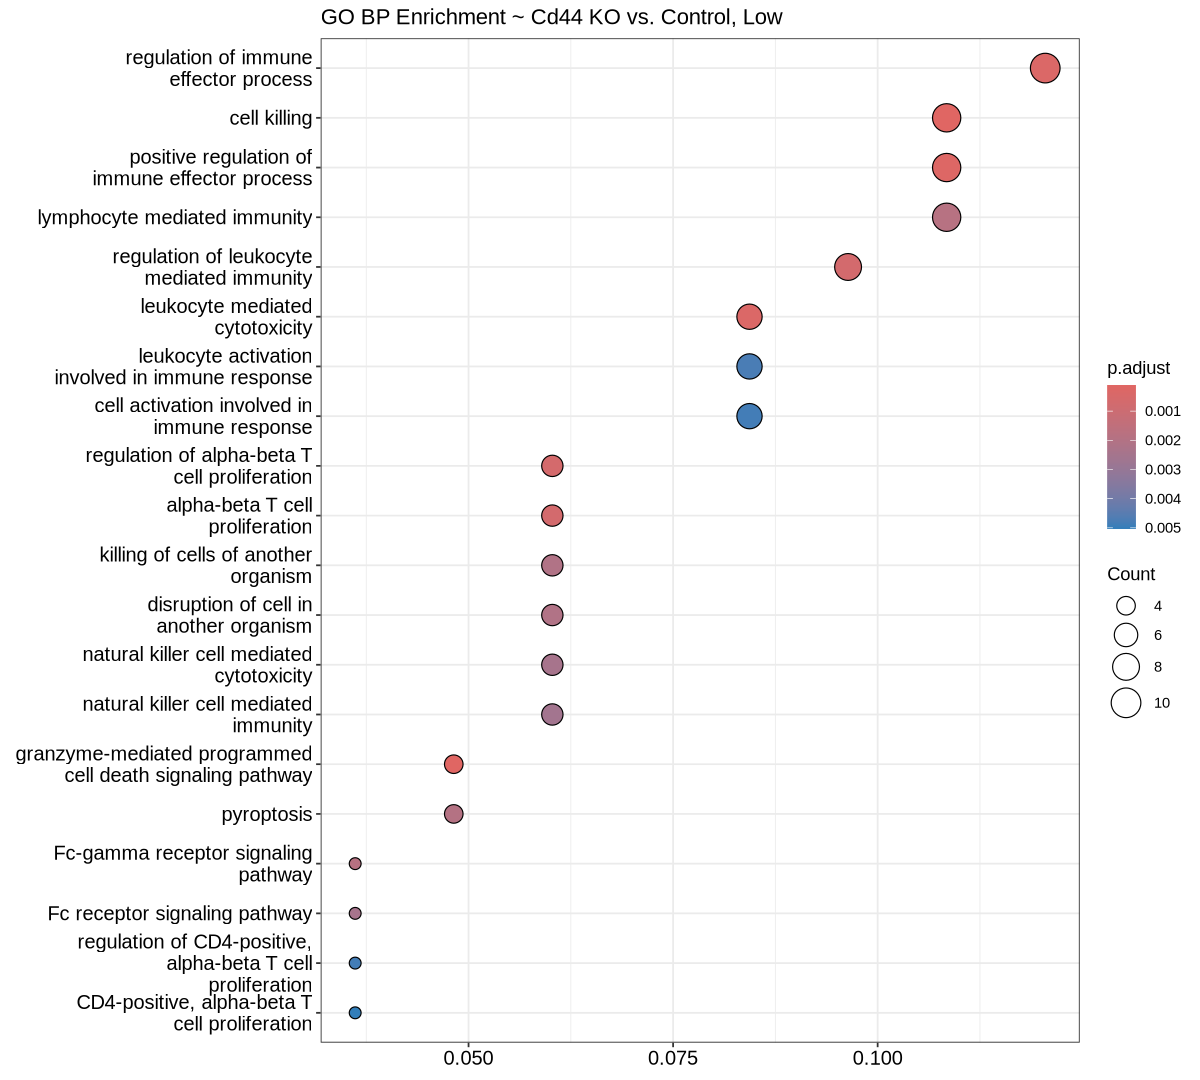

In [25]:
# _df <- msigdbr(species = "Mus musculus", category = "H")
# hallmark_sets <- m_df %>% select(c('gs_name', 'gene_symbol'))
# hallmark_enrich <- enricher(tab_high$Gene_name, TERM2GENE = hallmark_sets, pvalueCutoff = 0.05)

# hallmark_enrich@result$Description <- gsub("HALLMARK_", "", hallmark_enrich@result$Description)
# hallmark_enrich@result$color <- ifelse(hallmark_enrich@result$Description %in% c('EPITHELIAL_MESENCHYMAL_TRANSITION', 'INTERFERON_ALPHA_RESPONSE', 'INTERFERON_GAMMA_RESPONSE'), 'red', 'black')

# dotplot(hallmark_enrich, showCategory=20) + ggtitle("Hallmark Enrichment ~ Cd44 KO vs. Control") +
# theme(axis.title.x = element_blank(),  # 去除 x 轴标签
#       axis.title.y = element_blank())  # 去除 y 轴标签

go_enrich <- enrichGO(
  gene          = tab_low$Gene_name,
  OrgDb         = org.Mm.eg.db,  # 使用小鼠的基因数据库
  keyType       = "SYMBOL",      # 基因列表中的基因是符号形式
  ont           = "BP",          # 使用Biological Process
  pAdjustMethod = "BH",          # 使用Benjamini-Hochberg方法校正p值
  pvalueCutoff  = 0.05,          # p值阈值
  qvalueCutoff  = 0.05,          # q值阈值
  readable      = TRUE            # 将结果转换为更具可读性的基因名称
)

# 查看富集结果
# print(go_enrich)

# 如果有特定的条目需要标记颜色，可以像之前一样修改描述字段
# go_enrich@result$color <- ifelse(go_enrich@result$Description %in% c('apoptotic process', 'cell cycle', 'immune response'), 'red', 'black')

# 绘制富集分析结果的dotplot
dotplot(go_enrich, showCategory=20) + 
  ggtitle("GO BP Enrichment ~ Cd44 KO vs. Control, Low") +
  theme(axis.title.x = element_blank(),  # 去除 x 轴标签
        axis.title.y = element_blank())  # 去除 y 轴标签

In [10]:
deseq_results <- tab[order(tab$log2FoldChange, decreasing = TRUE), ]
geneList <- deseq_results$log2FoldChange
names(geneList) <- deseq_results$Gene_name
head(geneList)

2210418O10Rik       Gm45799          Tsix         Ptprv         Slfn5 
     9.705377      4.594727      3.352482      1.776543      1.723460 
         Hcn3 
     1.713796

In [ ]:
library(GO.db)

# 使用GSEA进行分析，假设您使用GO生物过程（BP）进行富集分析
gsea_results <- gseGO(
  geneList = geneList,
  OrgDb = org.Mm.eg.db,  # 或者使用适合您的物种，如小鼠：org.Mm.eg.db
  keyType = "SYMBOL",      # 基因列表中的基因是符号形式
  ont = "ALL",
  minGSSize = 2,
  maxGSSize = 1000,
  pvalueCutoff = 1,
  verbose = FALSE
)

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”


In [19]:
library(msigdbr)
library(clusterProfiler)
library(org.Mm.eg.db)

reactome_sets <- msigdbr(species = "Mus musculus", category = "C2", subcategory = "REACTOME") %>%
  # dplyr::filter(grepl("REACTOME", gs_name)) %>%
  dplyr::select(gs_name, gene_symbol)
geneList <- sort(geneList, decreasing = TRUE)
gsea_results <- GSEA(geneList, TERM2GENE = reactome_sets, pvalueCutoff = 1)

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...



In [21]:
# gsea_results@result[order(gsea_results@result$NES, decreasing=TRUE),] %>% head
show_df <- gsea_results@result[grep('IRON', gsea_results@result$Description, ignore.case=TRUE),]
show_df[order(show_df$NES, decreasing=TRUE),]

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
REACTOME_CYTOSOLIC_IRON_SULFUR_CLUSTER_ASSEMBLY,REACTOME_CYTOSOLIC_IRON_SULFUR_CLUSTER_ASSEMBLY,REACTOME_CYTOSOLIC_IRON_SULFUR_CLUSTER_ASSEMBLY,13,-0.3033004,-0.7907165,0.72088353,0.9231514,0.7933935,1245,"tags=46%, list=12%, signal=41%",Ciapin1/Pold1/Rtel1/Abcb7/Brip1/Ciao2b
REACTOME_IRON_UPTAKE_AND_TRANSPORT,REACTOME_IRON_UPTAKE_AND_TRANSPORT,REACTOME_IRON_UPTAKE_AND_TRANSPORT,38,-0.3077610,-1.0571237,0.36234818,0.6520614,0.5604078,2878,"tags=42%, list=27%, signal=31%",Atp6v0b/Flvcr1/Ubb/Glrx3/Atp6v1c1/Atp6v1b2/Cul1/Atp6v0e/Atp6v0a1/Atp6v1g1/Atp6v1f/Ftl1/Nedd8/Rps27a/Atp6v1d/Steap2
REACTOME_MITOCHONDRIAL_IRON_SULFUR_CLUSTER_BIOGENESIS,REACTOME_MITOCHONDRIAL_IRON_SULFUR_CLUSTER_BIOGENESIS,REACTOME_MITOCHONDRIAL_IRON_SULFUR_CLUSTER_BIOGENESIS,13,-0.5759094,-1.5014195,0.07228916,0.3027813,0.2602225,1302,"tags=54%, list=12%, signal=47%",Fdxr/Fdx2/Glrx5/Lyrm4/Fdx1/Hscb/Fxn


In [39]:
gsea_results@result$ID[gsea_results@result$ID == 'GO:0009991']

[1] "GO:0009991"

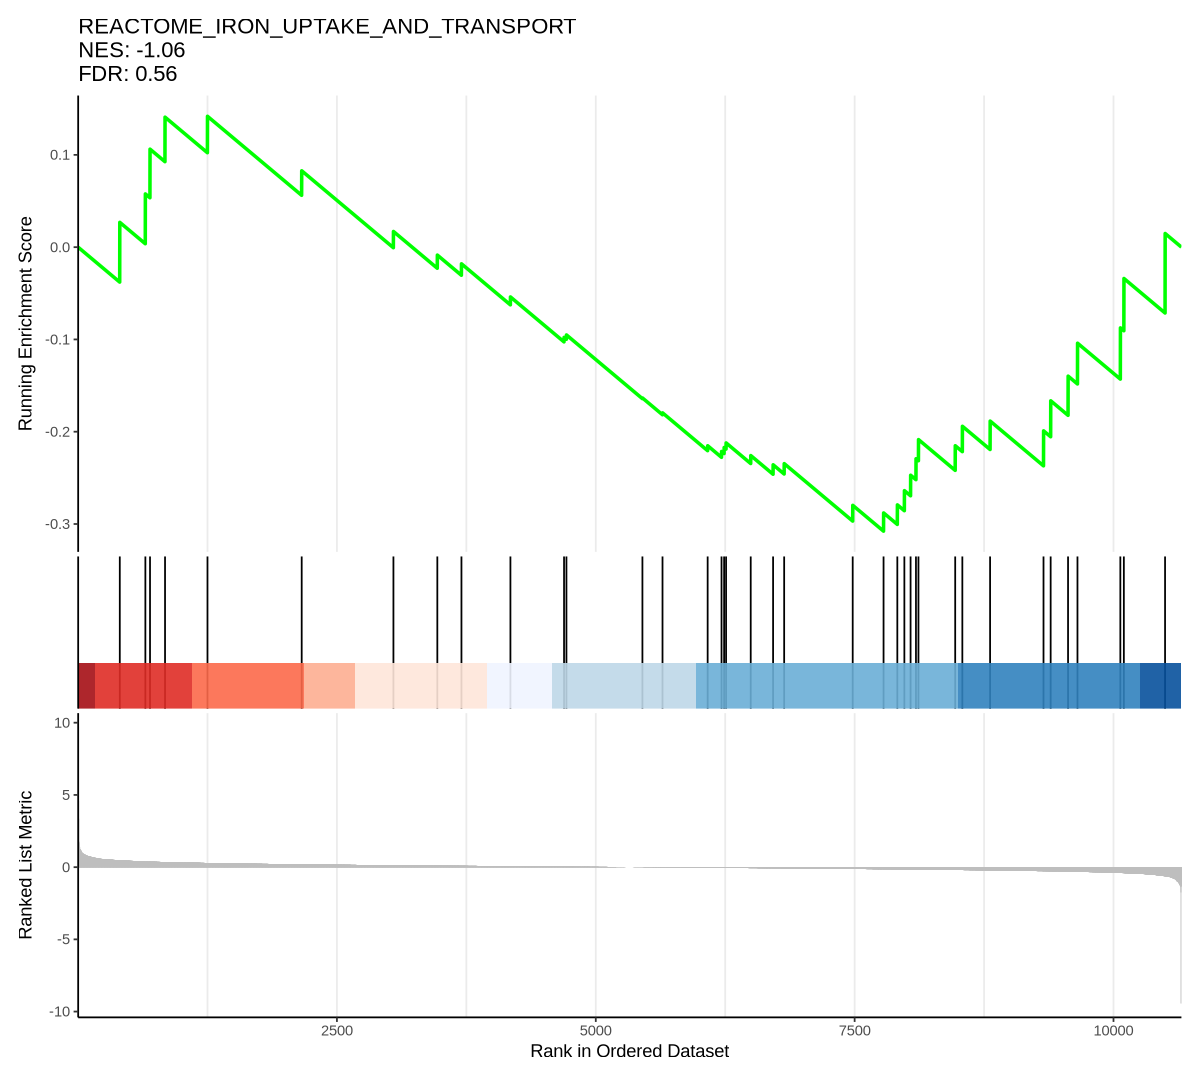

In [22]:
id = gsea_results@result$ID == 'REACTOME_IRON_UPTAKE_AND_TRANSPORT'
# gseaplot2(gsea_results, geneSetID = gsea_results@result$ID[id], title = gsea_results@result$Description[id])

p1 <- gseaplot2(
  gsea_results,
  geneSetID = c(gsea_results@result$ID[id]),
  title = paste(gsea_results@result$Description[id], "\nNES:", round(gsea_results@result$NES[id], 2),
    "\nFDR:", round(gsea_results@result$qvalue[id], 2)),
  color = "green"
)

print(p1)

# 保存为PDF文件
ggsave("./plots/T_iron_gsea_plots.pdf", plot = p1, width = 7, height = 4)

In [134]:
library(msigdbr)
library(clusterProfiler)
library(org.Mm.eg.db)

# Get MSigDB immune-related gene sets for mouse (C7 category)
immune_sets <- msigdbr(species = "Mus musculus", category = "C7") %>%
  dplyr::select(gs_name, gene_symbol)  # Ensure you're using gene symbols

# If your geneList is based on ENSEMBL or other identifiers, convert the immune_sets to match
# For example, if your geneList is in ENSEMBL, you can convert immune_sets as follows:
# immune_sets <- bitr(immune_sets$gene_symbol, fromType = "SYMBOL", toType = "SYMBOL", OrgDb = org.Mm.eg.db)

# Prepare geneList and ensure it is sorted
geneList <- sort(geneList, decreasing = TRUE)

# Run GSEA
gsea_results <- GSEA(geneList, TERM2GENE = immune_sets, pvalueCutoff = 1)


preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...



In [135]:
# Find indices of rows where the 'Description' contains the word 'memory'
memory_indices <- grep("MEMORY", gsea_results@result$Description, ignore.case = TRUE)

# Alternatively, if you want to return the descriptions themselves that contain the word 'memory'
memory_descriptions <- gsea_results@result$Description[memory_indices]

# Print the results
print(memory_descriptions)
print(memory_indices)


  [1] "GSE16522_MEMORY_VS_NAIVE_ANTI_CD3CD28_STIM_CD8_TCELL_DN"                                                               
  [2] "GOLDRATH_EFF_VS_MEMORY_CD8_TCELL_UP"                                                                                   
  [3] "GSE36476_CTRL_VS_TSST_ACT_72H_MEMORY_CD4_TCELL_YOUNG_DN"                                                               
  [4] "KAECH_DAY8_EFF_VS_MEMORY_CD8_TCELL_UP"                                                                                 
  [5] "GSE21360_NAIVE_VS_QUATERNARY_MEMORY_CD8_TCELL_DN"                                                                      
  [6] "GSE43863_TFH_VS_LY6C_INT_CXCR5POS_MEMORY_CD4_TCELL_UP"                                                                 
  [7] "GSE21360_NAIVE_VS_QUATERNARY_MEMORY_CD8_TCELL_UP"                                                                      
  [8] "GSE16522_MEMORY_VS_NAIVE_CD8_TCELL_DN"                                                                  

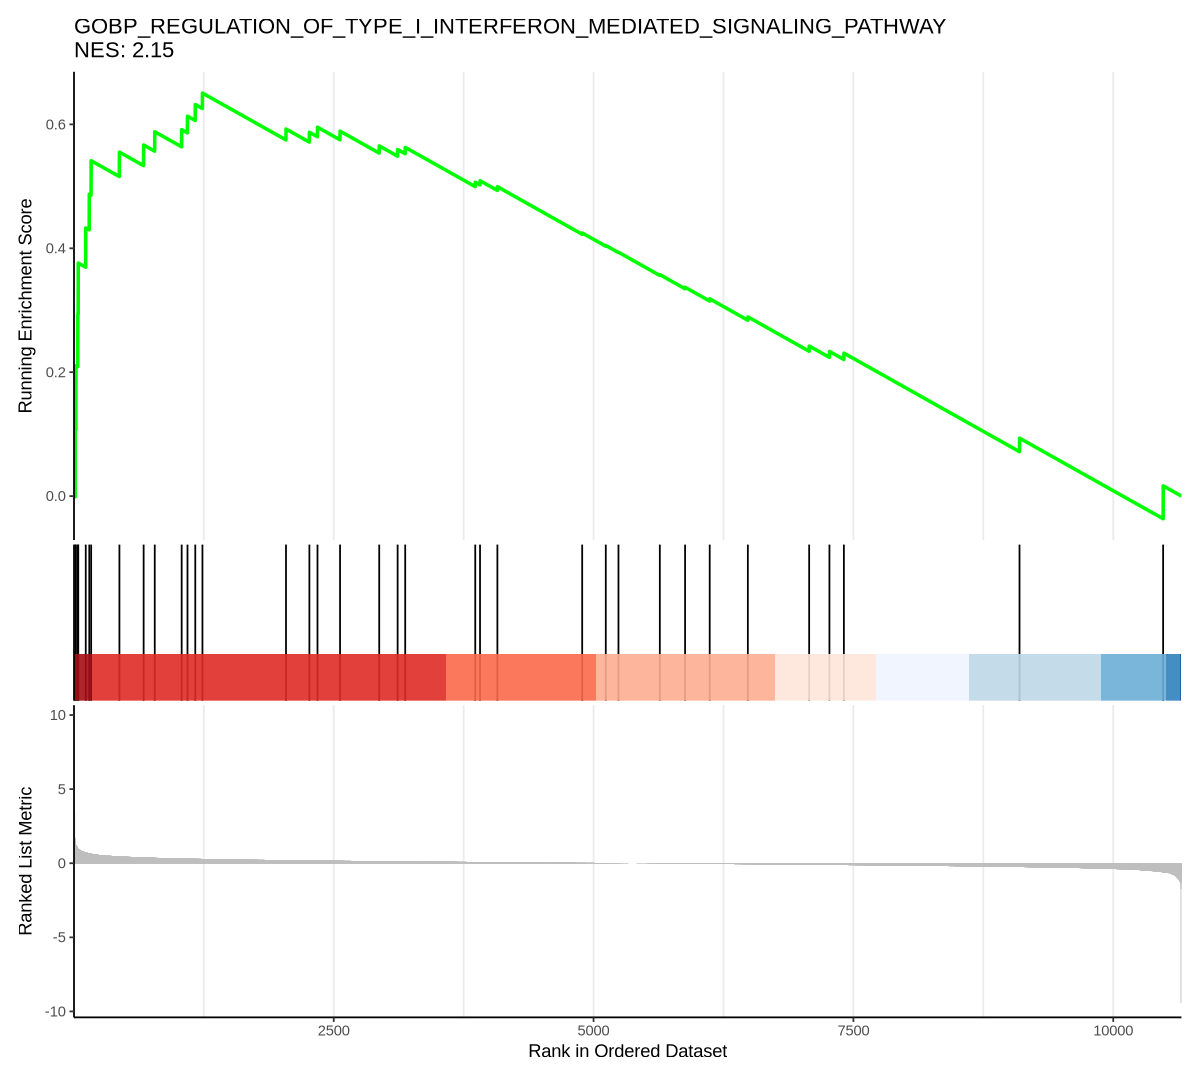

In [133]:
# 找到L2FC最大的pathway
max_l2fc_pathway <- gsea_results@result[gsea_results$Description == 'GOBP_REGULATION_OF_TYPE_I_INTERFERON_MEDIATED_SIGNALING_PATHWAY', ]

# 找到L2FC最小的pathway
min_l2fc_pathway <- gsea_results@result[which.min(gsea_results$NES), ]

# 绘制L2FC最大的pathway的GSEA图
p1 <- gseaplot2(
  gsea_results,
  geneSetID = max_l2fc_pathway$ID,
  title = paste(max_l2fc_pathway$Description, "\nNES:", round(max_l2fc_pathway$NES, 2)),
  color = "green"
)

# 绘制L2FC最小的pathway的GSEA图
# p2 <- gseaplot2(
#   gsea_results,
#   geneSetID = min_l2fc_pathway$ID,
#   title = min_l2fc_pathway$Description,
#   color = "green"
# )

# print(p2)
# 合并两个图像并保存
# combined_plot <- gridExtra::grid.arrange(c(p1, p2), ncol=2)

print(p1)


# 保存为PDF文件
# ggsave("./plots/T_interferon_gsea_plots.pdf", plot = p1, width = 7, height = 4)

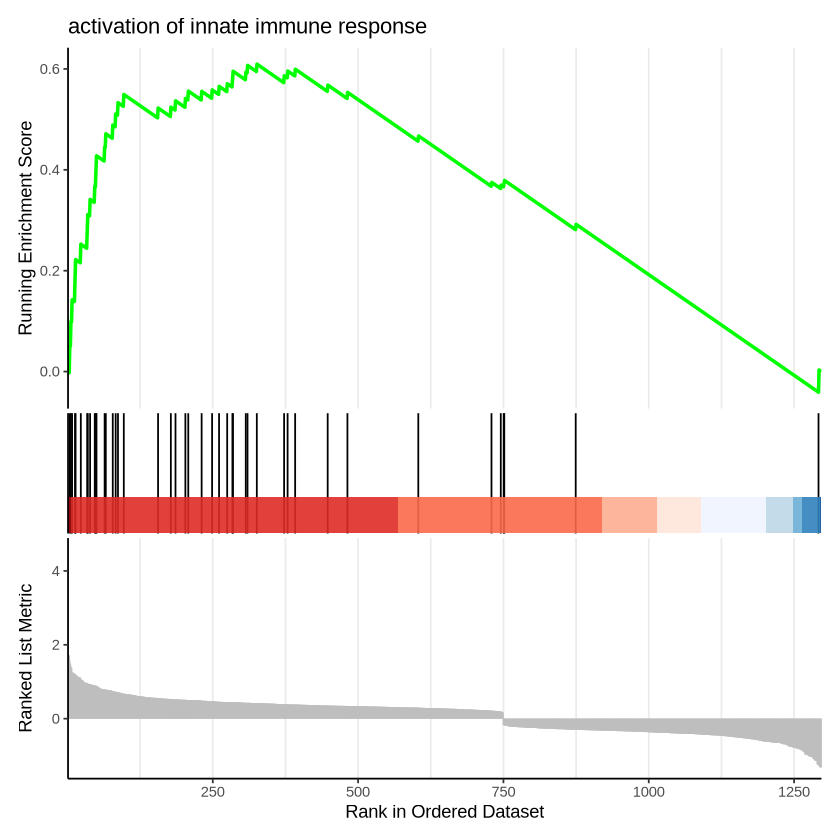

In [29]:
gseaplot2(gsea_results, geneSetID = gsea_results@result$ID[1], title = gsea_results@result$Description[1])

In [38]:
gseaplot2(gsea_results, geneSetID = gsea_results@result$ID[2], title = gsea_results@result$Description[2])

ERROR: Error in gsea_results@result: no applicable method for `@` applied to an object of class "data.frame"


In [13]:
write.table(go_enrich@result, 'down.csv', sep='\t', quote=F)

In [23]:
geneList <- tab_high$log2FoldChange
names(geneList) <- tab_high$Gene_name

geneList <- geneList %>% sort(decreasing=TRUE)
head(geneList)

Gm45799    Slfn5     Hcn3  Trim30d     Selp   Ifi208 
4.594727 1.723460 1.713796 1.547118 1.474450 1.402385

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“All values in the stats vector are greater than zero and scoreType is "std", maybe you should switch to scoreType = "pos".”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 9 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”
leading edge analysis...

done...



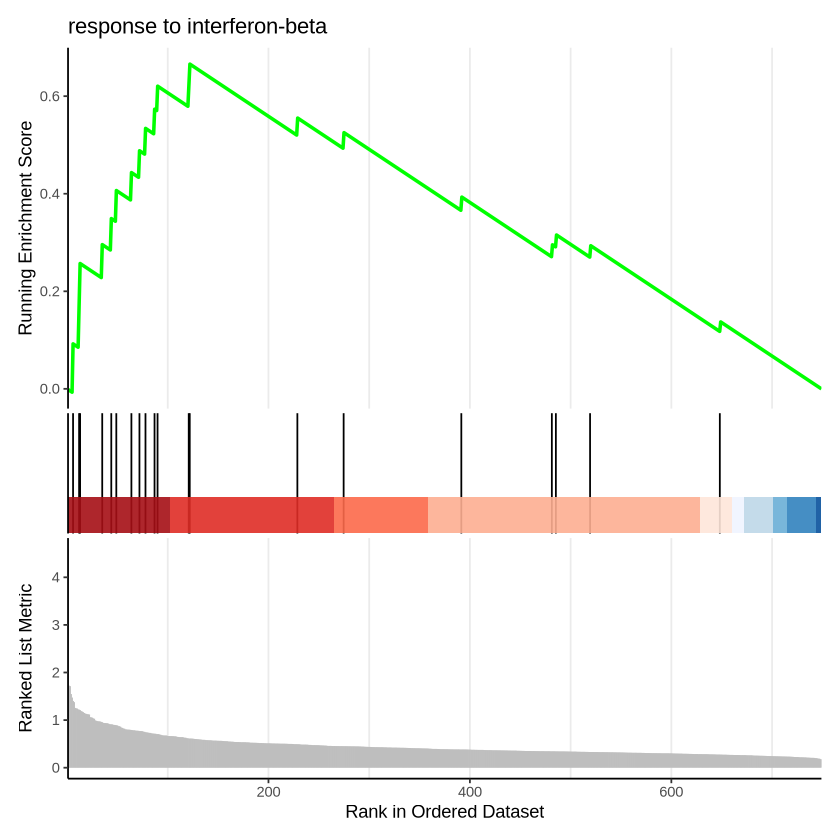

In [26]:
gsea_result <- gseGO(geneList = geneList, 
                     OrgDb = org.Mm.eg.db, 
                     ont = "BP", 
                     keyType = "SYMBOL",
                     minGSSize = 10, 
                     maxGSSize = 500, 
                     pvalueCutoff = 0.05, 
                     verbose = TRUE)

gseaplot2(gsea_result, geneSetID = gsea_result@result$ID[1], title = gsea_result@result$Description[1])

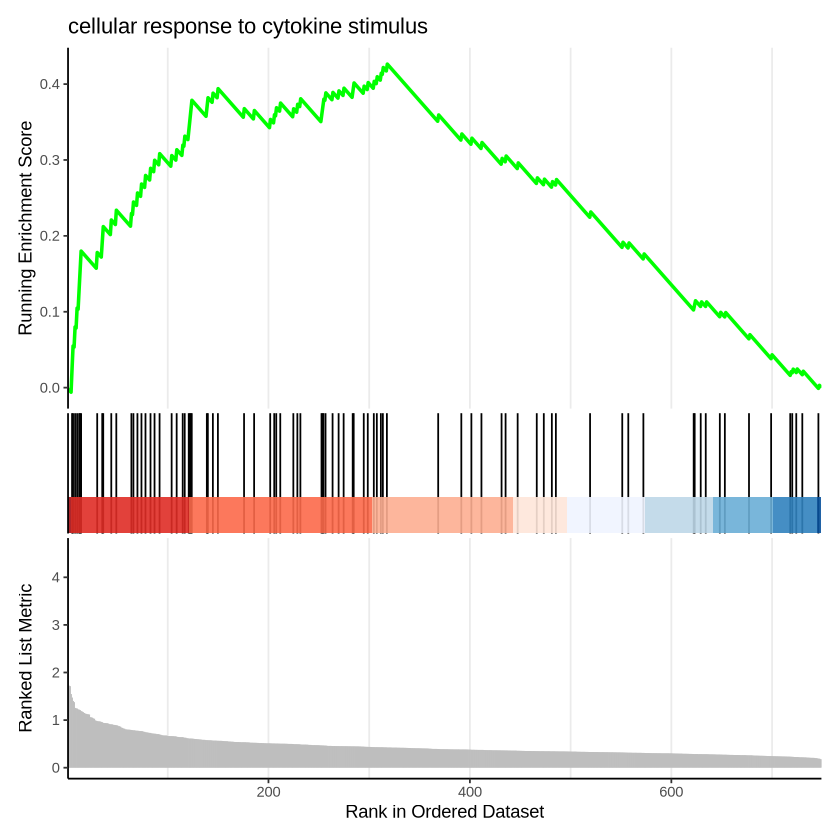

In [37]:
gseaplot2(gsea_result, geneSetID = gsea_result@result$ID[11], title = gsea_result@result$Description[11])

In [38]:
geneList <- tab_low$log2FoldChange
names(geneList) <- tab_low$Gene_name

geneList <- geneList %>% sort(decreasing=TRUE)
head(geneList)

Top2a    Csnk1a1     Havcr2       Cct4       Scd2    Tnfsf11 
-0.1704795 -0.1752146 -0.1824002 -0.1889301 -0.1897579 -0.1926670

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 28 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
leading edge analysis...

done...



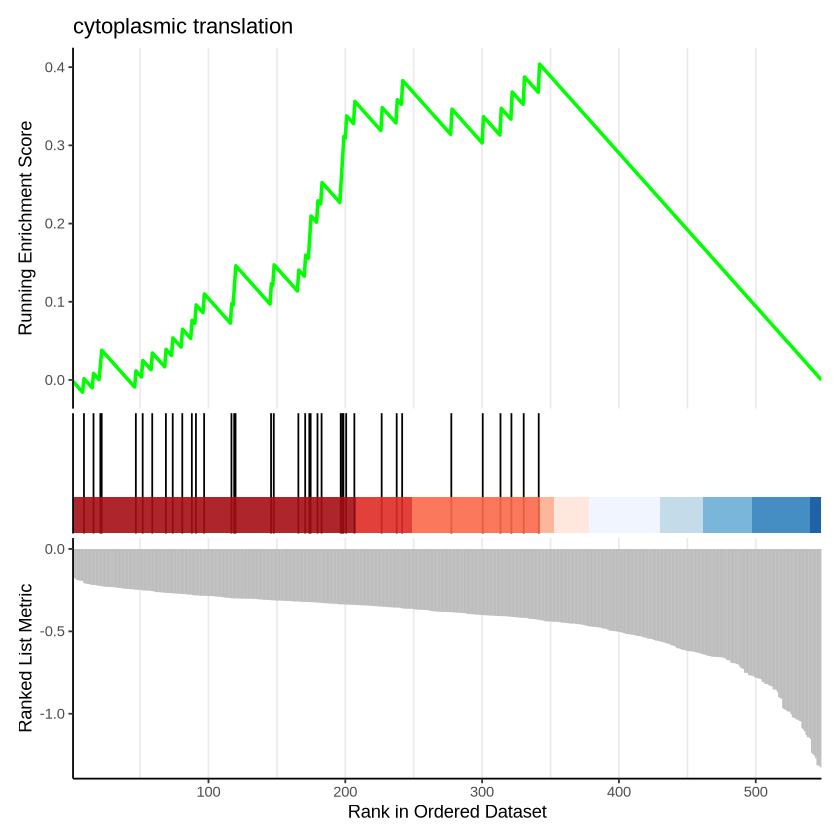

In [39]:
gsea_result_ <- gseGO(geneList = geneList, 
                     OrgDb = org.Mm.eg.db, 
                     ont = "BP", 
                     keyType = "SYMBOL",
                     minGSSize = 10, 
                     maxGSSize = 500, 
                     pvalueCutoff = 0.05, 
                     verbose = TRUE)

gseaplot2(gsea_result_, geneSetID = gsea_result_@result$ID[1], title = gsea_result_@result$Description[1])